In [1]:
#Loadiing Necessary Library for EDA and prediction\
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 20,12
import warnings
warnings.filterwarnings('ignore')
# Configuration
pd.set_option('max_column', None)
colors = sns.color_palette('Set2')
from tqdm.notebook import tqdm
tqdm.pandas()
from decimal import ROUND_HALF_UP, Decimal
from datetime import datetime, timedelta
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from multiprocessing import Pool, cpu_count
from dateutil.relativedelta import relativedelta, FR
# models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
path = 'C:/Users/shubh/Desktop/Python And Finance/jpx-tokyo-stock-exchange-prediction/train_files'

In [2]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")
    price['SecuritiesCode'] = price['SecuritiesCode'].astype(int)

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (df["CumulativeAdjustmentFactor"] * df["Close"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)))
        # reverse order
        df = df.sort_values("Date")
        # Generate cumulative adjustment factor volume
        df.loc[:, 'CumAdjustmentFactorVol'] = df['AdjustmentFactor'].cumprod()
        
        # generate AdjustedVolume 
        df['AdjustedVolume'] = df['Volume'].where(df['AdjustmentFactor'] != 1, (df['Volume'] * df['CumAdjustmentFactorVol']).astype('int64'))

        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        df.loc[df['AdjustedVolume']==0,'AdjustedVolume'] = np.nan
        df.loc[:, "AdjustedVolume"] = df.loc[:, "AdjustedVolume"].ffill()
        return df
      # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    

    price.set_index("Date","SecuritiesCode",inplace=True)
    return price

In [3]:
# load stock price data
df_price = pd.read_csv(f"{path}/stock_prices.csv")

# generate AdjustedClose
df_price = adjust_price(df_price)

# fetch prediction target SecuritiesCodes
codes = sorted(df_price["SecuritiesCode"].unique())


In [4]:
# technical indicators
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.DataFrame.ewm(u, com=period-1, adjust=False).mean() / \
         pd.DataFrame.ewm(d, com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

def bbands(price, length, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

def abands(df,length):
    #df['AB_Middle_Band'] = pd.rolling_mean(df['Close'], 20)
    df[f"AB_Middle_Band{length}_day"] = df['AdjustedClose'].rolling(window = length, center=False).mean()
    # High * ( 1 + 4 * (High - Low) / (High + Low))
    df['aupband'] = df['High'] * (1 + 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df[f"AB_Upper_Band{length}_day"] = df['aupband'].rolling(window=length, center=False).mean()
    # Low *(1 - 4 * (High - Low)/ (High + Low))
    df['adownband'] = df['Low'] * (1 - 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df[f"AB_Lower_Band{length}_day"] = df['adownband'].rolling(window=length, center=False).mean()
    return df[f"AB_Middle_Band{length}_day"],df[f"AB_Upper_Band{length}_day"] ,df[f"AB_Lower_Band{length}_day"]
    
def STOK(df, n):
    df[f'STOK{n}_days'] = ((df['AdjustedClose'] - df['Low'].rolling(window=n, center=False).mean()) / (df['High'].rolling(window=n, center=False).max() - df['Low'].rolling(window=n, center=False).min())) * 100
    df[f'STOD{n}_days'] = df[f'STOK{n}_days'].rolling(window = n, center=False).mean()
    return df[f'STOK{n}_days'],df[f'STOD{n}_days']

def CCI(df, n, constant):
    TP = (df['High'] + df['Low'] + df['AdjustedClose']) / 3
    CCI = pd.Series((TP - TP.rolling(window=n, center=False).mean()) / (constant * TP.rolling(window=n, center=False).std())) #, name = 'CCI_' + str(n))
    return CCI

def psar(df, iaf = 0.02, maxaf = 0.2):
    df.reset_index(inplace = True)
    length = len(df)
    dates = (df['Date'])
    high = (df['High'])
    low = (df['Low'])
    close = (df['AdjustedClose'])
    psar = df['AdjustedClose'][0:len(df['AdjustedClose'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['Low'][0]
    hp = df['High'][0]
    lp = df['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if df['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['Low'][i]
                af = iaf
        else:
            if df['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['High'][i]
                af = iaf
        if not reverse:
            if bull:
                if df['High'][i] > hp:
                    hp = df['High'][i]
                    af = min(af + iaf, maxaf)
                if df['Low'][i - 1] < psar[i]:
                    psar[i] = df['Low'][i - 1]
                if df['Low'][i - 2] < psar[i]:
                    psar[i] = df['Low'][i - 2]
            else:
                if df['Low'][i] < lp:
                    lp = df['Low'][i]
                    af = min(af + iaf, maxaf)
                if df['High'][i - 1] > psar[i]:
                    psar[i] = df['High'][i - 1]
                if df['High'][i - 2] > psar[i]:
                    psar[i] = df['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
    #return psar, psarbear, psarbull
    df['psar'] = psar
    #df['psarbear'] = psarbear
    #df['psarbull'] = psarbull
    
#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(((df['High'] + df['Low'] + df['AdjustedClose']) / 3).rolling(window =n, center=False).mean(), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['AdjustedClose']) / 3).rolling(window =n, center=False).mean(), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['AdjustedClose']) / 3).rolling(window =n, center=False).mean(), name = 'KelChD_' + str(n))    
    return KelChM, KelChD, KelChU

def MFI(df,n):
    # typical price
    df['tp'] = (df['High']+df['Low']+df['AdjustedClose'])/3
    #raw money flow
    df['rmf'] = df['tp'] * df['AdjustedVolume']
    
    # positive and negative money flow
    df['pmf'] = np.where(df['tp'] > df['tp'].shift(1), df['tp'], 0)
    df['nmf'] = np.where(df['tp'] < df['tp'].shift(1), df['tp'], 0)

    # money flow ratio
    df['mfr'] = df['pmf'].rolling(window=n,center=False).sum()/df['nmf'].rolling(window=n,center=False).sum()
    df['Money_Flow_Index'] = 100 - 100 / (1 + df['mfr'])
    return df['Money_Flow_Index'] 

def ichimoku(df):
    # Turning Line
    period9_high = df['High'].rolling(window=9,center=False).max()
    period9_low = df['Low'].rolling(window=9,center=False).min()
    df['turning_line'] = (period9_high + period9_low) / 2
    
    # Standard Line
    period26_high = df['High'].rolling(window=26,center=False).max()
    period26_low = df['Low'].rolling(window=26,center=False).min()
    df['standard_line'] = (period26_high + period26_low) / 2
    
    # Leading Span 1
    df['ichimoku_span1'] = ((df['turning_line'] + df['standard_line']) / 2).shift(26)
    
    # Leading Span 2
    period52_high = df['High'].rolling(window=52,center=False).max()
    period52_low = df['Low'].rolling(window=52,center=False).min()
    df['ichimoku_span2'] = ((period52_high + period52_low) / 2).shift(26)
    
    # The most current closing price plotted 22 time periods behind (optional)
    df['chikou_span'] = df['AdjustedClose'].shift(-22) # 22 according to investopedia
    
    return  df['ichimoku_span1'] , df['ichimoku_span2'], df['chikou_span']

def KAMA(price, n, pow1=2, pow2=30):
    ''' kama indicator '''    
    ''' accepts pandas dataframe of prices '''

    absDiffx = abs(price - price.shift(1) )  

    ER_num = abs( price - price.shift(n) )
    ER_den = absDiffx.rolling(window=n,center=False).sum()
    ER = ER_num / ER_den

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer


In [5]:
def get_features_for_predict(price, code):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
        code (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    close_col = "AdjustedClose"
    feats = price.loc[price["SecuritiesCode"] == code, ["SecuritiesCode","Target","Open","High","Low", close_col,"AdjustedVolume"]].copy()
    
    # feature engineering
    # 1day price momentum
    feats['Momentum_1D'] = (feats[close_col] - feats[close_col].shift(1))
    
    #Price Volume Trend
    feats["PVT"] = (feats["Momentum_1D"] - feats[close_col].shift(1)) * feats["AdjustedVolume"]
    feats["PVT"] = (feats["PVT"] - feats["PVT"].shift(1))
    
    for period in [5,10, 21, 63]:
        # return features
        feats[f"feature_return_{period}days"] = feats[close_col].pct_change(period)
        
        # historical volatility
        feats[f"feature_volatility_{period}days"] = (np.log(feats[close_col]).diff().rolling(period).std())
        
        # difference to moving-average
        feats[f"feature_MAgap_{period}days"] = feats[close_col].rolling(period).mean() / feats[close_col]
        
        # RSI
        feats[f"feature_RSI_{period}days"] = RSI(feats[close_col], period)
        
        #EMA
        feats[f"EMA{period}days"] = feats[close_col].ewm(span=period,adjust=False).mean()
        
         #BollingerBands
        
        feats[f"bollb{period}_mid"],feats[f"bollb{period}_up"],feats[f"bollb{period}_low"] = bbands(feats[close_col],length = period,numsd=2)
        
        #Acceleration Bands
        feats[f"AB_Middle_Band{period}_day"],feats[f"AB_Upper_Band{period}_day"] ,feats[f"AB_Lower_Band{period}_day"] = abands(feats,period)
        
        #Stochastic Oscilattor
        feats[f'STOK{period}_days'],feats[f'STOD{period}_days'] = STOK(feats,period)
        
        #CCI
        feats[f'CCI{period}_days'] = CCI(feats, period, 0.015)
        
        #ketner Channel
        feats[f'KelChM{period}'],feats[f'KelChD{period}'] ,feats[f'KelChU{period}'] = KELCH(feats,period)
        
        # money flow index
        feats[f'Money_Flow_Index{period}'] = MFI(feats,period)
        
        #KAMA
        feats[f'KAMA{period}_days'] = KAMA(feats[close_col],period)
        
        
    #Parabolic SAR
    feats["psar"] = psar(feats)
    
    #Ichimocu SPan
    feats['ichimoku_span1'] , feats['ichimoku_span2'], feats['chikou_span'] = ichimoku(feats)
        
        
     # filling data for nan and inf
    feats = feats.fillna(0)
    feats = feats.replace([np.inf, -np.inf], 0)
    # drop AdjustedClose column
    #feats = feats.drop([close_col], axis=1)
    columns2Drop = ['Momentum_1D','aupband', 'adownband','tp','rmf','pmf','nmf','mfr','Money_Flow_Index','turning_line','standard_line']
    feats = feats.drop(labels = columns2Drop, axis=1)
    #feats.set_index('Date',inplace = True)
    
    return feats

In [6]:
# generate feature
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(df_price, code)
    buff.append(feat)
feature_df = pd.concat(buff)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
options = pd.read_csv(f'{path}/options.csv',na_values='-')

In [8]:
def merge_options(df1, df2) :
    df2.loc[: ,"Date"] = pd.to_datetime(df2.loc[: ,"Date"], format="%Y-%m-%d")
    df2["GenSaki"] = df2["OptionsCode"].astype(str).str[1:2]
    df2["TargetIndex"] = df2["OptionsCode"].astype(str).str[5:]
    df2["Tot_Vol"] = df2["TradingVolume"].sum()
    df2["Tot_Vol_day"] = df2["WholeDayVolume"].sum()
    df2["Relative Volatility"] = df2["ImpliedVolatility"]/df2["BaseVolatility"]

    #df2 = df2[df2["TargetIndex"]=="0018"]
    #df2 = df2[df2["GenSaki"]== "3"]
    df2 = df2[df2["Putcall"]== 1]
    df2["Put_Vol"] = df2["TradingVolume"].sum()
    df2["Call_Vol"] = df2["Tot_Vol"] - df2["Put_Vol"]
    df2["Put_ratio"] = df2["Put_Vol"] / df2["Tot_Vol"]
    df2["Call_ratio"] = df2["Call_Vol"] / df2["Tot_Vol"]
    df2["Put_Vol_day"] = df2["WholeDayVolume"].sum()
    df2["Call_Vol_day"] =  df2["Tot_Vol_day"] - df2["Put_Vol_day"]
    df2["Put_ratio_day" ] = df2["Put_Vol_day"]/df2["Tot_Vol_day"]
    df2["Cal_ratio_day"] = df2["Call_Vol_day"]/df2["Tot_Vol_day"]
    df2["Call_call_ratio"] = df2["Call_Vol_day"]/df2["Call_Vol"]
    df2["Put_put_ratio"] = df2["Put_Vol_day"]/df2["Put_Vol"]
    
    df2 = df2[["Date","Relative Volatility","InterestRate","Put_ratio","Call_ratio","Put_ratio_day","Cal_ratio_day","Call_call_ratio","Put_put_ratio"]]
    df2 = df2.groupby("Date").mean().reset_index()    
    df1 = pd.merge(df1, df2, on = "Date", how="left")
    df1.set_index("Date","SecuritiesCode",inplace=True)    
    
    return df1

final_feat= merge_options(feature_df,options)

In [9]:
# split data into TRAIN and TEST
TRAIN_END = '2019-12-31'
# We put a week gap between TRAIN_END and TEST_START
# to avoid leakage of test data information from label
TEST_START = '2020-01-06'

In [10]:
def get_label(price, code):
    """ Labelizer
    Args:
        price (pd.DataFrame): dataframe of stock_price.csv
        code (int): Local Code in the universe
    Returns:
        df (pd.DataFrame): label data
    """
    df = price.loc[price["SecuritiesCode"] == code].copy()
    df.loc[:, "label"] = df["Target"]

    return df.loc[:, ["SecuritiesCode", "label"]]

def get_features_and_label(price, codes, features):
    """
    Args:
        price (pd.DataFrame): loaded price data
        codes  (array) : target codes
        feature (pd.DataFrame): features
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X\
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # to store splited data
    trains_X, tests_X = [], []
    trains_y, tests_y = [], []

    # generate feature one by one
    for code in tqdm(codes):

        feats = features[features["SecuritiesCode"] == code].dropna()
        labels = get_label(price, code).dropna()

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # align label and feature indexes
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]

            assert (labels.loc[:, "SecuritiesCode"] == feats.loc[:, "SecuritiesCode"]).all()
            labels = labels.loc[:, "label"]

            # split data into TRAIN and TEST
            _train_X = feats[: TRAIN_END]
            _test_X = feats[TEST_START:]

            _train_y = labels[: TRAIN_END]
            _test_y = labels[TEST_START:]
            
            assert len(_train_X) == len(_train_y)
            assert len(_test_X) == len(_test_y)

            # store features
            trains_X.append(_train_X)
            tests_X.append(_test_X)
            # store labels
            trains_y.append(_train_y)
            tests_y.append(_test_y)
            
    # combine features for each codes
    train_X = pd.concat(trains_X)
    test_X = pd.concat(tests_X)
    # combine label for each codes
    train_y = pd.concat(trains_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, test_X, test_y

In [11]:
# train test split
train_X, train_y, test_X, test_y = get_features_and_label(df_price, codes, final_feat)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
# features to use
feat_cols = []
for cols in final_feat.columns:
    feat_cols.append(cols)

In [13]:
feat_cols = feat_cols[6:]

In [19]:
import optuna

def objectives(trial):
    # optunaでのハイパーパラメータサーチ範囲の設定
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 300, 4000),
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
            'max_bin': trial.suggest_int('max_bin', 2, 100),
            'learning_rate': trial.suggest_uniform('learning_rate',0, 1),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(train_X[feat_cols], train_y, eval_set=[(test_X[feat_cols], test_y)], verbose=10)
    score = model.score(train_X[feat_cols], train_y )
    return score

In [20]:
opt = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=0))
opt.optimize(objectives, n_trials=20)

# 最適パラメータ取得
trial = opt.best_trial
params_best = dict(trial.params.items())
params_best['random_seed'] = 0
    
# 最適パラメータで学習/予測    
pred_model = lgb.LGBMRegressor(**params_best)#

[I 2022-07-04 01:39:56,827] A new study created in memory with name: no-name-29352a08-96ee-4b2e-b605-162eaabec145


[10]	valid_0's l2: 0.000765636
[20]	valid_0's l2: 0.000792211
[30]	valid_0's l2: 0.000820006
[40]	valid_0's l2: 0.000830571
[50]	valid_0's l2: 0.000840298
[60]	valid_0's l2: 0.000854499
[70]	valid_0's l2: 0.000862721
[80]	valid_0's l2: 0.000866763
[90]	valid_0's l2: 0.000872243
[100]	valid_0's l2: 0.000877569
[110]	valid_0's l2: 0.000885355
[120]	valid_0's l2: 0.000890016
[130]	valid_0's l2: 0.000894427
[140]	valid_0's l2: 0.000897525
[150]	valid_0's l2: 0.000899519
[160]	valid_0's l2: 0.000902453
[170]	valid_0's l2: 0.000905097
[180]	valid_0's l2: 0.000909043
[190]	valid_0's l2: 0.000911898
[200]	valid_0's l2: 0.000913451
[210]	valid_0's l2: 0.000914695
[220]	valid_0's l2: 0.000915784
[230]	valid_0's l2: 0.000916699
[240]	valid_0's l2: 0.000917481
[250]	valid_0's l2: 0.000918455
[260]	valid_0's l2: 0.000919593
[270]	valid_0's l2: 0.000920505
[280]	valid_0's l2: 0.000921297
[290]	valid_0's l2: 0.00092187
[300]	valid_0's l2: 0.000922509
[310]	valid_0's l2: 0.000923359
[320]	valid_0's l2

[I 2022-07-04 01:44:14,268] Trial 0 finished with value: 0.9984511909750515 and parameters: {'num_leaves': 2331, 'n_estimators': 718, 'max_bin': 61, 'learning_rate': 0.5448831829968969}. Best is trial 0 with value: 0.9984511909750515.


[10]	valid_0's l2: 0.000861815
[20]	valid_0's l2: 0.000920105
[30]	valid_0's l2: 0.000961845
[40]	valid_0's l2: 0.00099219
[50]	valid_0's l2: 0.00101626
[60]	valid_0's l2: 0.001036
[70]	valid_0's l2: 0.00104699
[80]	valid_0's l2: 0.00107515
[90]	valid_0's l2: 0.00109351
[100]	valid_0's l2: 0.00110407
[110]	valid_0's l2: 0.00111168
[120]	valid_0's l2: 0.00111916
[130]	valid_0's l2: 0.00112581
[140]	valid_0's l2: 0.00113322
[150]	valid_0's l2: 0.00113854
[160]	valid_0's l2: 0.00114176
[170]	valid_0's l2: 0.00114803
[180]	valid_0's l2: 0.00115184
[190]	valid_0's l2: 0.0011612
[200]	valid_0's l2: 0.0011646
[210]	valid_0's l2: 0.00117032
[220]	valid_0's l2: 0.00117331
[230]	valid_0's l2: 0.00117698
[240]	valid_0's l2: 0.00117886
[250]	valid_0's l2: 0.00118103
[260]	valid_0's l2: 0.00118271
[270]	valid_0's l2: 0.00118463
[280]	valid_0's l2: 0.00118593
[290]	valid_0's l2: 0.00118734
[300]	valid_0's l2: 0.00118828
[310]	valid_0's l2: 0.00118944
[320]	valid_0's l2: 0.00119081
[330]	valid_0's l2

[I 2022-07-04 01:47:41,405] Trial 1 finished with value: 0.9981949810986991 and parameters: {'num_leaves': 1867, 'n_estimators': 650, 'max_bin': 45, 'learning_rate': 0.8917730007820798}. Best is trial 0 with value: 0.9984511909750515.


[10]	valid_0's l2: 0.000958558
[20]	valid_0's l2: 0.000981211
[30]	valid_0's l2: 0.000999929
[40]	valid_0's l2: 0.00100873
[50]	valid_0's l2: 0.0010198
[60]	valid_0's l2: 0.00103198
[70]	valid_0's l2: 0.00103823
[80]	valid_0's l2: 0.00104156
[90]	valid_0's l2: 0.00104598
[100]	valid_0's l2: 0.00105018
[110]	valid_0's l2: 0.0010581
[120]	valid_0's l2: 0.00106097
[130]	valid_0's l2: 0.00106184
[140]	valid_0's l2: 0.00106425
[150]	valid_0's l2: 0.00106593
[160]	valid_0's l2: 0.00106809
[170]	valid_0's l2: 0.00106833
[180]	valid_0's l2: 0.00106975
[190]	valid_0's l2: 0.00107077
[200]	valid_0's l2: 0.00107199
[210]	valid_0's l2: 0.00107247
[220]	valid_0's l2: 0.00107307
[230]	valid_0's l2: 0.00107374
[240]	valid_0's l2: 0.00107413
[250]	valid_0's l2: 0.0010746
[260]	valid_0's l2: 0.00107482
[270]	valid_0's l2: 0.00107499
[280]	valid_0's l2: 0.00107529
[290]	valid_0's l2: 0.00107544
[300]	valid_0's l2: 0.00107563
[310]	valid_0's l2: 0.00107574
[320]	valid_0's l2: 0.00107581
[330]	valid_0's l

[I 2022-07-04 01:51:38,817] Trial 2 finished with value: 0.9974821759797178 and parameters: {'num_leaves': 3866, 'n_estimators': 389, 'max_bin': 80, 'learning_rate': 0.5288949197529045}. Best is trial 0 with value: 0.9984511909750515.


[10]	valid_0's l2: 0.00066733
[20]	valid_0's l2: 0.000664229
[30]	valid_0's l2: 0.000667278
[40]	valid_0's l2: 0.000669308
[50]	valid_0's l2: 0.000671407
[60]	valid_0's l2: 0.000673675
[70]	valid_0's l2: 0.000675177
[80]	valid_0's l2: 0.000676382
[90]	valid_0's l2: 0.000677321
[100]	valid_0's l2: 0.000678163
[110]	valid_0's l2: 0.000678799
[120]	valid_0's l2: 0.000679465
[130]	valid_0's l2: 0.000680337
[140]	valid_0's l2: 0.000680897
[150]	valid_0's l2: 0.000681545
[160]	valid_0's l2: 0.000682407
[170]	valid_0's l2: 0.00068305
[180]	valid_0's l2: 0.000683509
[190]	valid_0's l2: 0.000684041
[200]	valid_0's l2: 0.00068447
[210]	valid_0's l2: 0.000685008
[220]	valid_0's l2: 0.000685548
[230]	valid_0's l2: 0.000686414
[240]	valid_0's l2: 0.000687005
[250]	valid_0's l2: 0.000688087
[260]	valid_0's l2: 0.000688753
[270]	valid_0's l2: 0.000689136
[280]	valid_0's l2: 0.000689566
[290]	valid_0's l2: 0.000690015
[300]	valid_0's l2: 0.000690625
[310]	valid_0's l2: 0.000691403
[320]	valid_0's l2: 

[I 2022-07-04 01:56:21,240] Trial 3 finished with value: 0.8071938640985099 and parameters: {'num_leaves': 2402, 'n_estimators': 927, 'max_bin': 9, 'learning_rate': 0.08712929970154071}. Best is trial 0 with value: 0.9984511909750515.


[10]	valid_0's l2: 0.000777435
[20]	valid_0's l2: 0.000830398
[30]	valid_0's l2: 0.000855484
[40]	valid_0's l2: 0.000899033
[50]	valid_0's l2: 0.000912917
[60]	valid_0's l2: 0.000937948
[70]	valid_0's l2: 0.000948127
[80]	valid_0's l2: 0.000957001
[90]	valid_0's l2: 0.000982918
[100]	valid_0's l2: 0.000994146
[110]	valid_0's l2: 0.00100219
[120]	valid_0's l2: 0.00102707
[130]	valid_0's l2: 0.00103409
[140]	valid_0's l2: 0.00104173
[150]	valid_0's l2: 0.00105618
[160]	valid_0's l2: 0.00106098
[170]	valid_0's l2: 0.00106687
[180]	valid_0's l2: 0.00107211
[190]	valid_0's l2: 0.0010768
[200]	valid_0's l2: 0.00107958
[210]	valid_0's l2: 0.00108298
[220]	valid_0's l2: 0.00108705
[230]	valid_0's l2: 0.00109646
[240]	valid_0's l2: 0.00110003
[250]	valid_0's l2: 0.00110316
[260]	valid_0's l2: 0.00110698
[270]	valid_0's l2: 0.00111096
[280]	valid_0's l2: 0.0011154
[290]	valid_0's l2: 0.00111837
[300]	valid_0's l2: 0.0011236
[310]	valid_0's l2: 0.00112636
[320]	valid_0's l2: 0.00113106
[330]	vali

[I 2022-07-04 01:58:55,756] Trial 4 finished with value: 0.8951048059671218 and parameters: {'num_leaves': 374, 'n_estimators': 835, 'max_bin': 79, 'learning_rate': 0.8700121482468192}. Best is trial 0 with value: 0.9984511909750515.


[10]	valid_0's l2: 0.000864309
[20]	valid_0's l2: 0.000927845
[30]	valid_0's l2: 0.000969594
[40]	valid_0's l2: 0.000989466
[50]	valid_0's l2: 0.00100591
[60]	valid_0's l2: 0.00101519
[70]	valid_0's l2: 0.00103747
[80]	valid_0's l2: 0.00104876
[90]	valid_0's l2: 0.00105472
[100]	valid_0's l2: 0.00106013
[110]	valid_0's l2: 0.00106501
[120]	valid_0's l2: 0.00106887
[130]	valid_0's l2: 0.00107238
[140]	valid_0's l2: 0.00107522
[150]	valid_0's l2: 0.00107711
[160]	valid_0's l2: 0.0010794
[170]	valid_0's l2: 0.00108173
[180]	valid_0's l2: 0.00108345
[190]	valid_0's l2: 0.0010852
[200]	valid_0's l2: 0.00108582
[210]	valid_0's l2: 0.00108729
[220]	valid_0's l2: 0.00108823
[230]	valid_0's l2: 0.00108879
[240]	valid_0's l2: 0.00108914
[250]	valid_0's l2: 0.00108955
[260]	valid_0's l2: 0.00108997
[270]	valid_0's l2: 0.00109017
[280]	valid_0's l2: 0.00109021
[290]	valid_0's l2: 0.00109035
[300]	valid_0's l2: 0.00109058
[310]	valid_0's l2: 0.00109083
[320]	valid_0's l2: 0.00109113
[330]	valid_0's

[I 2022-07-04 02:07:05,083] Trial 5 finished with value: 0.9999043357599486 and parameters: {'num_leaves': 3921, 'n_estimators': 801, 'max_bin': 47, 'learning_rate': 0.7805291762864555}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000754503
[20]	valid_0's l2: 0.000820891
[30]	valid_0's l2: 0.000881217
[40]	valid_0's l2: 0.000908539
[50]	valid_0's l2: 0.000932399
[60]	valid_0's l2: 0.000946675
[70]	valid_0's l2: 0.000965171
[80]	valid_0's l2: 0.00098783
[90]	valid_0's l2: 0.00100333
[100]	valid_0's l2: 0.00101555
[110]	valid_0's l2: 0.00102863
[120]	valid_0's l2: 0.00104017
[130]	valid_0's l2: 0.0010504
[140]	valid_0's l2: 0.00106649
[150]	valid_0's l2: 0.00107368
[160]	valid_0's l2: 0.0010811
[170]	valid_0's l2: 0.00108888
[180]	valid_0's l2: 0.00109648
[190]	valid_0's l2: 0.00110093
[200]	valid_0's l2: 0.00110772
[210]	valid_0's l2: 0.00111226
[220]	valid_0's l2: 0.00111729
[230]	valid_0's l2: 0.00112204
[240]	valid_0's l2: 0.00112839
[250]	valid_0's l2: 0.00113332
[260]	valid_0's l2: 0.00113711
[270]	valid_0's l2: 0.00114157
[280]	valid_0's l2: 0.00114694
[290]	valid_0's l2: 0.00115099
[300]	valid_0's l2: 0.00115438
[310]	valid_0's l2: 0.00115985
[320]	valid_0's l2: 0.0011632
[330]	valid_0

[I 2022-07-04 02:09:16,510] Trial 6 finished with value: 0.9233627156194789 and parameters: {'num_leaves': 737, 'n_estimators': 644, 'max_bin': 16, 'learning_rate': 0.9446689170495839}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000814689
[20]	valid_0's l2: 0.000856669
[30]	valid_0's l2: 0.000887291
[40]	valid_0's l2: 0.000912851
[50]	valid_0's l2: 0.000933911
[60]	valid_0's l2: 0.000944061
[70]	valid_0's l2: 0.000958377
[80]	valid_0's l2: 0.000971444
[90]	valid_0's l2: 0.000985528
[100]	valid_0's l2: 0.000993739
[110]	valid_0's l2: 0.00100116
[120]	valid_0's l2: 0.00100877
[130]	valid_0's l2: 0.00101358
[140]	valid_0's l2: 0.00101844
[150]	valid_0's l2: 0.00102277
[160]	valid_0's l2: 0.00102759
[170]	valid_0's l2: 0.00103192
[180]	valid_0's l2: 0.00103479
[190]	valid_0's l2: 0.00103746
[200]	valid_0's l2: 0.00104057
[210]	valid_0's l2: 0.00104236
[220]	valid_0's l2: 0.00104473
[230]	valid_0's l2: 0.00104737
[240]	valid_0's l2: 0.00104912
[250]	valid_0's l2: 0.0010503
[260]	valid_0's l2: 0.00105265
[270]	valid_0's l2: 0.0010541
[280]	valid_0's l2: 0.00105531
[290]	valid_0's l2: 0.00105623
[300]	valid_0's l2: 0.00105708
[310]	valid_0's l2: 0.00105816
[320]	valid_0's l2: 0.00105931
[330]	val

[I 2022-07-04 02:12:04,911] Trial 7 finished with value: 0.9892671406941455 and parameters: {'num_leaves': 2231, 'n_estimators': 420, 'max_bin': 28, 'learning_rate': 0.7742336894342167}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000697193
[20]	valid_0's l2: 0.00071387
[30]	valid_0's l2: 0.000724296
[40]	valid_0's l2: 0.000735722
[50]	valid_0's l2: 0.000743819
[60]	valid_0's l2: 0.000751739
[70]	valid_0's l2: 0.000759912
[80]	valid_0's l2: 0.000766149
[90]	valid_0's l2: 0.000772266
[100]	valid_0's l2: 0.000778715
[110]	valid_0's l2: 0.000783468
[120]	valid_0's l2: 0.000789486
[130]	valid_0's l2: 0.000795322
[140]	valid_0's l2: 0.000799783
[150]	valid_0's l2: 0.000802076
[160]	valid_0's l2: 0.000806791
[170]	valid_0's l2: 0.000810051
[180]	valid_0's l2: 0.00081325
[190]	valid_0's l2: 0.000815786
[200]	valid_0's l2: 0.000818834
[210]	valid_0's l2: 0.000821467
[220]	valid_0's l2: 0.000823999
[230]	valid_0's l2: 0.000827635
[240]	valid_0's l2: 0.000831191
[250]	valid_0's l2: 0.000833841
[260]	valid_0's l2: 0.000836188
[270]	valid_0's l2: 0.00083825
[280]	valid_0's l2: 0.000840162
[290]	valid_0's l2: 0.000842984
[300]	valid_0's l2: 0.000844517
[310]	valid_0's l2: 0.000846843
[320]	valid_0's l2: 

[I 2022-07-04 02:14:48,541] Trial 8 finished with value: 0.4920827668628125 and parameters: {'num_leaves': 1988, 'n_estimators': 573, 'max_bin': 3, 'learning_rate': 0.6176354970758771}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000821511
[20]	valid_0's l2: 0.000863207
[30]	valid_0's l2: 0.000890986
[40]	valid_0's l2: 0.000911062
[50]	valid_0's l2: 0.000928647
[60]	valid_0's l2: 0.000942191
[70]	valid_0's l2: 0.000954415
[80]	valid_0's l2: 0.000969648
[90]	valid_0's l2: 0.000985105
[100]	valid_0's l2: 0.000990526
[110]	valid_0's l2: 0.000995499
[120]	valid_0's l2: 0.000999026
[130]	valid_0's l2: 0.00100504
[140]	valid_0's l2: 0.00100786
[150]	valid_0's l2: 0.00101033
[160]	valid_0's l2: 0.00101225
[170]	valid_0's l2: 0.00101413
[180]	valid_0's l2: 0.00101573
[190]	valid_0's l2: 0.00101748
[200]	valid_0's l2: 0.00101923
[210]	valid_0's l2: 0.00102075
[220]	valid_0's l2: 0.00102277
[230]	valid_0's l2: 0.00102373
[240]	valid_0's l2: 0.00102426
[250]	valid_0's l2: 0.00102491
[260]	valid_0's l2: 0.00102559
[270]	valid_0's l2: 0.00102681
[280]	valid_0's l2: 0.00102758
[290]	valid_0's l2: 0.0010281
[300]	valid_0's l2: 0.00102868
[310]	valid_0's l2: 0.00102912
[320]	valid_0's l2: 0.00102941
[330]	

[I 2022-07-04 02:20:00,426] Trial 9 finished with value: 0.9994405719677942 and parameters: {'num_leaves': 2565, 'n_estimators': 621, 'max_bin': 95, 'learning_rate': 0.6818202991034834}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000701387
[20]	valid_0's l2: 0.000759096
[30]	valid_0's l2: 0.00080576
[40]	valid_0's l2: 0.000821622
[50]	valid_0's l2: 0.000817213
[60]	valid_0's l2: 0.000816044
[70]	valid_0's l2: 0.000815496
[80]	valid_0's l2: 0.000816191
[90]	valid_0's l2: 0.000816257
[100]	valid_0's l2: 0.000815454
[110]	valid_0's l2: 0.000816237
[120]	valid_0's l2: 0.00081563
[130]	valid_0's l2: 0.000816891
[140]	valid_0's l2: 0.000816571
[150]	valid_0's l2: 0.000816472
[160]	valid_0's l2: 0.000817085
[170]	valid_0's l2: 0.000817432
[180]	valid_0's l2: 0.000817927
[190]	valid_0's l2: 0.000818228
[200]	valid_0's l2: 0.000818225
[210]	valid_0's l2: 0.000817901
[220]	valid_0's l2: 0.000818162
[230]	valid_0's l2: 0.000818526
[240]	valid_0's l2: 0.000818549
[250]	valid_0's l2: 0.000818821
[260]	valid_0's l2: 0.000819102
[270]	valid_0's l2: 0.00081972
[280]	valid_0's l2: 0.000819998
[290]	valid_0's l2: 0.000819956
[300]	valid_0's l2: 0.000820648
[310]	valid_0's l2: 0.000821174
[320]	valid_0's l2: 

[I 2022-07-04 02:23:34,991] Trial 10 finished with value: 0.632048246479409 and parameters: {'num_leaves': 1630, 'n_estimators': 443, 'max_bin': 71, 'learning_rate': 0.06022547162926983}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000667696
[20]	valid_0's l2: 0.000668311
[30]	valid_0's l2: 0.000674957
[40]	valid_0's l2: 0.000679288
[50]	valid_0's l2: 0.000682354
[60]	valid_0's l2: 0.000686039
[70]	valid_0's l2: 0.000690032
[80]	valid_0's l2: 0.000691296
[90]	valid_0's l2: 0.000695031
[100]	valid_0's l2: 0.000698079
[110]	valid_0's l2: 0.000699992
[120]	valid_0's l2: 0.000702598
[130]	valid_0's l2: 0.00070324
[140]	valid_0's l2: 0.000705255
[150]	valid_0's l2: 0.000707197
[160]	valid_0's l2: 0.000709107
[170]	valid_0's l2: 0.000709564
[180]	valid_0's l2: 0.000710265
[190]	valid_0's l2: 0.000710984
[200]	valid_0's l2: 0.000712427
[210]	valid_0's l2: 0.000712996
[220]	valid_0's l2: 0.000714109
[230]	valid_0's l2: 0.000714497
[240]	valid_0's l2: 0.000715114
[250]	valid_0's l2: 0.000715816
[260]	valid_0's l2: 0.000716922
[270]	valid_0's l2: 0.000717341
[280]	valid_0's l2: 0.000717949
[290]	valid_0's l2: 0.000718696
[300]	valid_0's l2: 0.000719021
[310]	valid_0's l2: 0.000718973
[320]	valid_0's l2

[I 2022-07-04 02:29:16,970] Trial 11 finished with value: 0.9022023335898269 and parameters: {'num_leaves': 2767, 'n_estimators': 674, 'max_bin': 22, 'learning_rate': 0.1289262976548533}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000724415
[20]	valid_0's l2: 0.000745493
[30]	valid_0's l2: 0.000765517
[40]	valid_0's l2: 0.000782024
[50]	valid_0's l2: 0.000793998
[60]	valid_0's l2: 0.000804436
[70]	valid_0's l2: 0.000810641
[80]	valid_0's l2: 0.000817994
[90]	valid_0's l2: 0.000822481
[100]	valid_0's l2: 0.000826972
[110]	valid_0's l2: 0.000829576
[120]	valid_0's l2: 0.000832248
[130]	valid_0's l2: 0.000835759
[140]	valid_0's l2: 0.000838365
[150]	valid_0's l2: 0.000842398
[160]	valid_0's l2: 0.000843804
[170]	valid_0's l2: 0.000845777
[180]	valid_0's l2: 0.000847913
[190]	valid_0's l2: 0.000849794
[200]	valid_0's l2: 0.000851134
[210]	valid_0's l2: 0.000852981
[220]	valid_0's l2: 0.000854107
[230]	valid_0's l2: 0.000855492
[240]	valid_0's l2: 0.000856967
[250]	valid_0's l2: 0.000858049
[260]	valid_0's l2: 0.000858981
[270]	valid_0's l2: 0.000860171
[280]	valid_0's l2: 0.000861237
[290]	valid_0's l2: 0.000861891
[300]	valid_0's l2: 0.00086317
[310]	valid_0's l2: 0.000864275
[320]	valid_0's l2

[I 2022-07-04 02:31:06,460] Trial 12 finished with value: 0.9119073702579152 and parameters: {'num_leaves': 1467, 'n_estimators': 370, 'max_bin': 58, 'learning_rate': 0.43860151346232035}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000669924
[20]	valid_0's l2: 0.000676754
[30]	valid_0's l2: 0.000686244
[40]	valid_0's l2: 0.000692637
[50]	valid_0's l2: 0.000697205
[60]	valid_0's l2: 0.000700899
[70]	valid_0's l2: 0.000703754
[80]	valid_0's l2: 0.000705952
[90]	valid_0's l2: 0.000707878
[100]	valid_0's l2: 0.000711835
[110]	valid_0's l2: 0.000714329


[I 2022-07-04 02:32:35,334] Trial 13 finished with value: 0.6652518440580532 and parameters: {'num_leaves': 3957, 'n_estimators': 111, 'max_bin': 22, 'learning_rate': 0.16130951788499626}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000722665
[20]	valid_0's l2: 0.000728021
[30]	valid_0's l2: 0.000734372
[40]	valid_0's l2: 0.000742264
[50]	valid_0's l2: 0.000746907
[60]	valid_0's l2: 0.000749123
[70]	valid_0's l2: 0.000754493
[80]	valid_0's l2: 0.000758961
[90]	valid_0's l2: 0.000761248
[100]	valid_0's l2: 0.000766181
[110]	valid_0's l2: 0.00076818
[120]	valid_0's l2: 0.000771261
[130]	valid_0's l2: 0.000773023
[140]	valid_0's l2: 0.00077439
[150]	valid_0's l2: 0.000776268
[160]	valid_0's l2: 0.000778953
[170]	valid_0's l2: 0.000779728
[180]	valid_0's l2: 0.00078108
[190]	valid_0's l2: 0.00078195
[200]	valid_0's l2: 0.000783363
[210]	valid_0's l2: 0.000784096
[220]	valid_0's l2: 0.000785747
[230]	valid_0's l2: 0.000786666
[240]	valid_0's l2: 0.000787658
[250]	valid_0's l2: 0.000788227
[260]	valid_0's l2: 0.000788732


[I 2022-07-04 02:34:45,227] Trial 14 finished with value: 0.8704285868114784 and parameters: {'num_leaves': 2717, 'n_estimators': 261, 'max_bin': 48, 'learning_rate': 0.24442559200160274}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000789654
[20]	valid_0's l2: 0.000834171
[30]	valid_0's l2: 0.000833391
[40]	valid_0's l2: 0.000833068
[50]	valid_0's l2: 0.000834787
[60]	valid_0's l2: 0.000837559
[70]	valid_0's l2: 0.000838369
[80]	valid_0's l2: 0.000838712
[90]	valid_0's l2: 0.000839546
[100]	valid_0's l2: 0.000839099
[110]	valid_0's l2: 0.000839283


[I 2022-07-04 02:35:31,349] Trial 15 finished with value: 0.4548325382292868 and parameters: {'num_leaves': 888, 'n_estimators': 119, 'max_bin': 66, 'learning_rate': 0.1381829513486138}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.00067794
[20]	valid_0's l2: 0.000682361
[30]	valid_0's l2: 0.000678012
[40]	valid_0's l2: 0.00067791
[50]	valid_0's l2: 0.000678841
[60]	valid_0's l2: 0.000679265
[70]	valid_0's l2: 0.000679226
[80]	valid_0's l2: 0.000680399
[90]	valid_0's l2: 0.000681122
[100]	valid_0's l2: 0.000682757
[110]	valid_0's l2: 0.000683846
[120]	valid_0's l2: 0.000684782
[130]	valid_0's l2: 0.000686234
[140]	valid_0's l2: 0.00068741
[150]	valid_0's l2: 0.000688145
[160]	valid_0's l2: 0.000689663
[170]	valid_0's l2: 0.000690062
[180]	valid_0's l2: 0.00069135
[190]	valid_0's l2: 0.000691578
[200]	valid_0's l2: 0.000692118
[210]	valid_0's l2: 0.000693754
[220]	valid_0's l2: 0.000693965
[230]	valid_0's l2: 0.000694251
[240]	valid_0's l2: 0.000695027
[250]	valid_0's l2: 0.000695215
[260]	valid_0's l2: 0.000695839
[270]	valid_0's l2: 0.00069609
[280]	valid_0's l2: 0.000696936
[290]	valid_0's l2: 0.000697275
[300]	valid_0's l2: 0.000697574
[310]	valid_0's l2: 0.000697779
[320]	valid_0's l2: 0.

[I 2022-07-04 02:37:19,774] Trial 16 finished with value: 0.59956508582265 and parameters: {'num_leaves': 1027, 'n_estimators': 375, 'max_bin': 83, 'learning_rate': 0.09710127579306127}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000795815
[20]	valid_0's l2: 0.000832179
[30]	valid_0's l2: 0.000845978
[40]	valid_0's l2: 0.00085517
[50]	valid_0's l2: 0.000862905
[60]	valid_0's l2: 0.000871425
[70]	valid_0's l2: 0.000881477
[80]	valid_0's l2: 0.000885007
[90]	valid_0's l2: 0.000889875
[100]	valid_0's l2: 0.000893953


[I 2022-07-04 02:38:32,362] Trial 17 finished with value: 0.8590888543154928 and parameters: {'num_leaves': 3401, 'n_estimators': 105, 'max_bin': 98, 'learning_rate': 0.4686512016477016}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000678902
[20]	valid_0's l2: 0.000720416
[30]	valid_0's l2: 0.000756435
[40]	valid_0's l2: 0.00078882
[50]	valid_0's l2: 0.000807734
[60]	valid_0's l2: 0.000819853
[70]	valid_0's l2: 0.000824797
[80]	valid_0's l2: 0.000824368
[90]	valid_0's l2: 0.000823309
[100]	valid_0's l2: 0.000823005
[110]	valid_0's l2: 0.000822734
[120]	valid_0's l2: 0.000823383
[130]	valid_0's l2: 0.000824102
[140]	valid_0's l2: 0.000824265
[150]	valid_0's l2: 0.00082445
[160]	valid_0's l2: 0.000824886
[170]	valid_0's l2: 0.000824766
[180]	valid_0's l2: 0.000824968
[190]	valid_0's l2: 0.000825477
[200]	valid_0's l2: 0.000825686
[210]	valid_0's l2: 0.000825976
[220]	valid_0's l2: 0.00082619
[230]	valid_0's l2: 0.000826605
[240]	valid_0's l2: 0.000826857
[250]	valid_0's l2: 0.000826993
[260]	valid_0's l2: 0.00082712
[270]	valid_0's l2: 0.000827772
[280]	valid_0's l2: 0.000828083
[290]	valid_0's l2: 0.000828487
[300]	valid_0's l2: 0.00082873
[310]	valid_0's l2: 0.000829068
[320]	valid_0's l2: 0.

[I 2022-07-04 02:46:03,481] Trial 18 finished with value: 0.7822947126376933 and parameters: {'num_leaves': 3914, 'n_estimators': 609, 'max_bin': 75, 'learning_rate': 0.039187792254320675}. Best is trial 5 with value: 0.9999043357599486.


[10]	valid_0's l2: 0.000665932
[20]	valid_0's l2: 0.000656337
[30]	valid_0's l2: 0.000658477
[40]	valid_0's l2: 0.000658991
[50]	valid_0's l2: 0.000660973
[60]	valid_0's l2: 0.000662604
[70]	valid_0's l2: 0.000664302
[80]	valid_0's l2: 0.000666508
[90]	valid_0's l2: 0.000667595
[100]	valid_0's l2: 0.000669692
[110]	valid_0's l2: 0.000671909
[120]	valid_0's l2: 0.000673466


[I 2022-07-04 02:47:17,243] Trial 19 finished with value: 0.4661340304289392 and parameters: {'num_leaves': 1346, 'n_estimators': 129, 'max_bin': 31, 'learning_rate': 0.11872771895424405}. Best is trial 5 with value: 0.9999043357599486.


In [21]:
#lgbm_params = {
   # 'n_estimators': 10000,
   # 'num_leaves': 2 ** 4 + 1,
   # 'objective': 'huber',
   # 'metric': 'mae',
   # 'boosting_type': 'gbdt',
    #'max_depth': 4,
   # 'learning_rate': 0.01,
   # 'feature_fraction': 0.4,
    #'lambda_l1': 0.1,
  #  'lambda_l2': 1,
   # 'seed': 46,
  #  'early_stopping_rounds': 100,
#}    
# initialize model
#pred_model = lgb.LGBMRegressor(**lgbm_params)

# train
pred_model.fit(
    train_X[feat_cols], train_y
    , eval_set=[(test_X[feat_cols], test_y)]
    , verbose=10
)

# save
#pred_model.booster_.save_model(os.path.join(path, "model.txt"))
# prepare result data
result = test_X[["SecuritiesCode"]].copy()

# predict
result.loc[:, "predict"] = pred_model.predict(test_X[feat_cols])

# actual result
result.loc[:, "Target"] = test_y.values

def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values("predict", ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank"] = np.arange(len(df["predict"]))
    return df

result = result.sort_values(["Date", "predict"], ascending=[True, False])
result = result.groupby("Date").apply(set_rank)

[10]	valid_0's l2: 0.000872889
[20]	valid_0's l2: 0.000925286
[30]	valid_0's l2: 0.000963733
[40]	valid_0's l2: 0.000997475
[50]	valid_0's l2: 0.0010139
[60]	valid_0's l2: 0.00102766
[70]	valid_0's l2: 0.00103612
[80]	valid_0's l2: 0.00104309
[90]	valid_0's l2: 0.00105116
[100]	valid_0's l2: 0.00105572
[110]	valid_0's l2: 0.00106043
[120]	valid_0's l2: 0.00106396
[130]	valid_0's l2: 0.00106812
[140]	valid_0's l2: 0.00107036
[150]	valid_0's l2: 0.00107257
[160]	valid_0's l2: 0.00107464
[170]	valid_0's l2: 0.00107633
[180]	valid_0's l2: 0.00107755
[190]	valid_0's l2: 0.00107933
[200]	valid_0's l2: 0.00108023
[210]	valid_0's l2: 0.00108048
[220]	valid_0's l2: 0.00108083
[230]	valid_0's l2: 0.00108143
[240]	valid_0's l2: 0.00108181
[250]	valid_0's l2: 0.00108197
[260]	valid_0's l2: 0.00108229
[270]	valid_0's l2: 0.00108256
[280]	valid_0's l2: 0.00108279
[290]	valid_0's l2: 0.00108282
[300]	valid_0's l2: 0.00108314
[310]	valid_0's l2: 0.00108308
[320]	valid_0's l2: 0.00108312
[330]	valid_0'

<AxesSubplot:xlabel='importance', ylabel='features'>

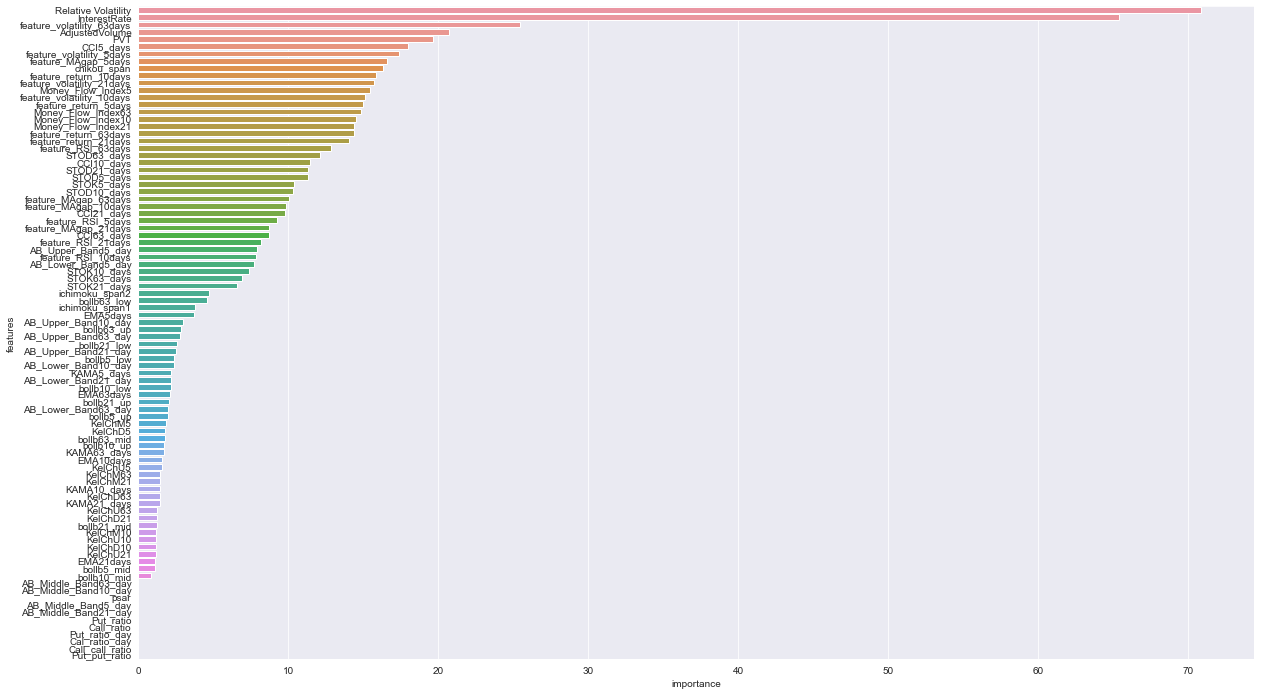

In [23]:
# feature importance
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = feat_cols
feature_importance_df['importance'] = pred_model.booster_.feature_importance(importance_type="gain")

sns.barplot(x='importance', y='features', data=feature_importance_df.sort_values(by=['importance'], ascending=False))

In [24]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        
        weights = np.linspace(start = toprank_weight_ratio, stop = 1, num=portfolio_size)
        
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    
    return sharpe_ratio

def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        
        weights = np.linspace(start = toprank_weight_ratio, stop = 1, num=portfolio_size)
        
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        
        return purchase - short

In [26]:
calc_spread_return_sharpe(result, portfolio_size = 200)

0.7888625695567479

<AxesSubplot:xlabel='Date'>

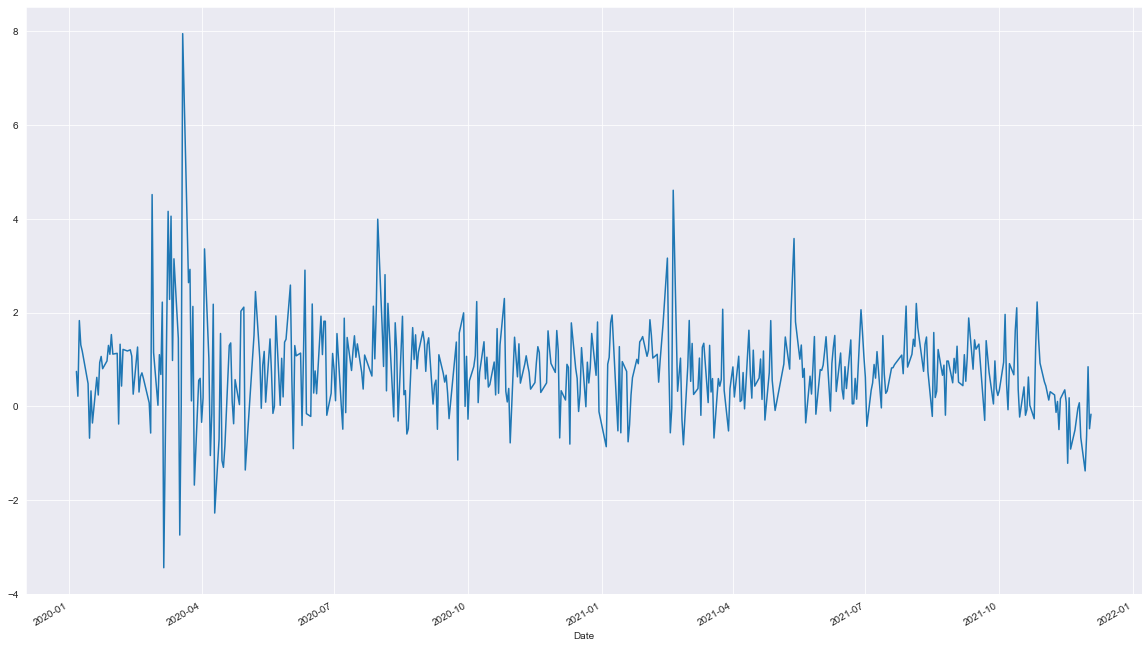

In [25]:
# we will show daily spread return of the model.
df_result = result.groupby('Date').apply(_calc_spread_return_per_day, 200, 2)
df_result.plot()

<AxesSubplot:xlabel='Date'>

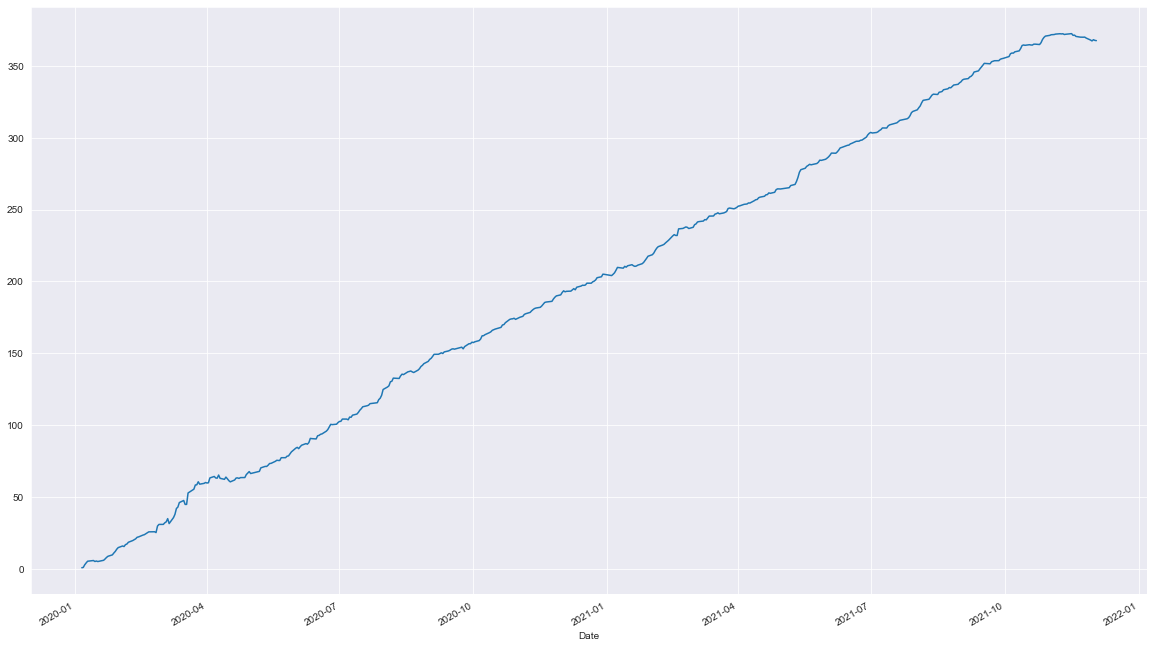

In [27]:
# a cumulative spread return of the mode
df_result.cumsum().plot()

In [28]:
result

,SecuritiesCode,predict,Target,Rank
Date,,,,
2020-01-06,4767,0.069928,-0.009082,0
2020-01-06,4479,0.066263,-0.043478,1
2020-01-06,3856,0.063976,-0.022530,2
2020-01-06,4483,0.063165,0.022727,3
2020-01-06,6966,0.062653,-0.031492,4
...,...,...,...,...
2021-12-03,8159,-0.096625,0.023047,1995
2021-12-03,6047,-0.104089,-0.020464,1996
2021-12-03,2491,-0.105491,0.031385,1997
